# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import glob
from macrohet import dataio, tile, tools

In [5]:
# import sys
# sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [62]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def return_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    return img

## Load images

In [4]:
expt_ID = 'ND0002'
base_dir = f'/mnt/NEMO/home/users/dayn/macrohet_nemo/{expt_ID}/'
metadata_fn = os.path.join(base_dir, 'acquisition/Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*AssayLayout.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/388620 [00:00<?, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    2         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    10         WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
    12         WT      BDQ          0.02            EC50
4   3          WT     CTRL             0             EC0
    4          WT     CTRL             0             EC0
    5          WT      PZA           400            EC99
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    10         WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
    12         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    6         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    8         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    10        RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
    12        RD1      BDQ          0.02            EC50
6   3         RD1     CTRL             0             EC0
    4         RD1     CTRL             0             EC0
    5         RD1      PZA           400            EC99
    6         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    8         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    10        RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99
    12        RD1      BDQ           2.5            EC99

In [6]:
acq_ID = row, column = (3, 4)

In [87]:
20.44 *3 * 24

1471.6800000000003

In [44]:
# image = cv2.imread('images/mphi.png')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ch1 = cv2.imread('images/ch01.png')
# ch1 = cv2.cvtColor(ch1, cv2.COLOR_BGR2RGB)

# ch2= cv2.imread('images/ch02.png')
# ch2 = cv2.cvtColor(ch2, cv2.COLOR_BGR2RGB)

image_dir = os.path.join(base_dir, 'acquisition/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='max_proj',
                             # set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
images

dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [90]:
images

dask.array<max-aggregate, shape=(150, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [48]:
test_frame_rgb.shape

(6048, 6048, 3)

In [51]:
%%time

test_frame = images[0]

test_frame_rgb = np.zeros(test_frame[0].shape + (3,),  dtype=test_frame[0].dtype)# rgb_image = np.zeros((6048, 6048, 3), dtype=img.dtype)

# Assign the first channel of img to the green channel in the RGB image
test_frame_rgb[:, :, 0] = test_frame[0]

# Assign the second channel of img to the red channel in the RGB image
test_frame_rgb[:, :, 1] = test_frame[1]

CPU times: user 2min 36s, sys: 24.2 s, total: 3min 1s
Wall time: 33 s


In [57]:
test_frame_rgb_8bit = cv2.convertScaleAbs(test_frame_rgb, alpha=(255.0/65535.0))


In [58]:
v = napari.Viewer()
v.add_image(test_frame_rgb)
v.add_image(test_frame_rgb_8bit)

<Image layer 'test_frame_rgb_8bit' at 0x7f98310703d0>

#### This conversion loses quite a lot of fidelity... but might be okay just for segmentation purposes

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:

sam_checkpoint = "/home/dayn/analysis/models/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
%%time # cpu was 11min
anns = mask_generator.generate(test_frame_rgb_8bit)

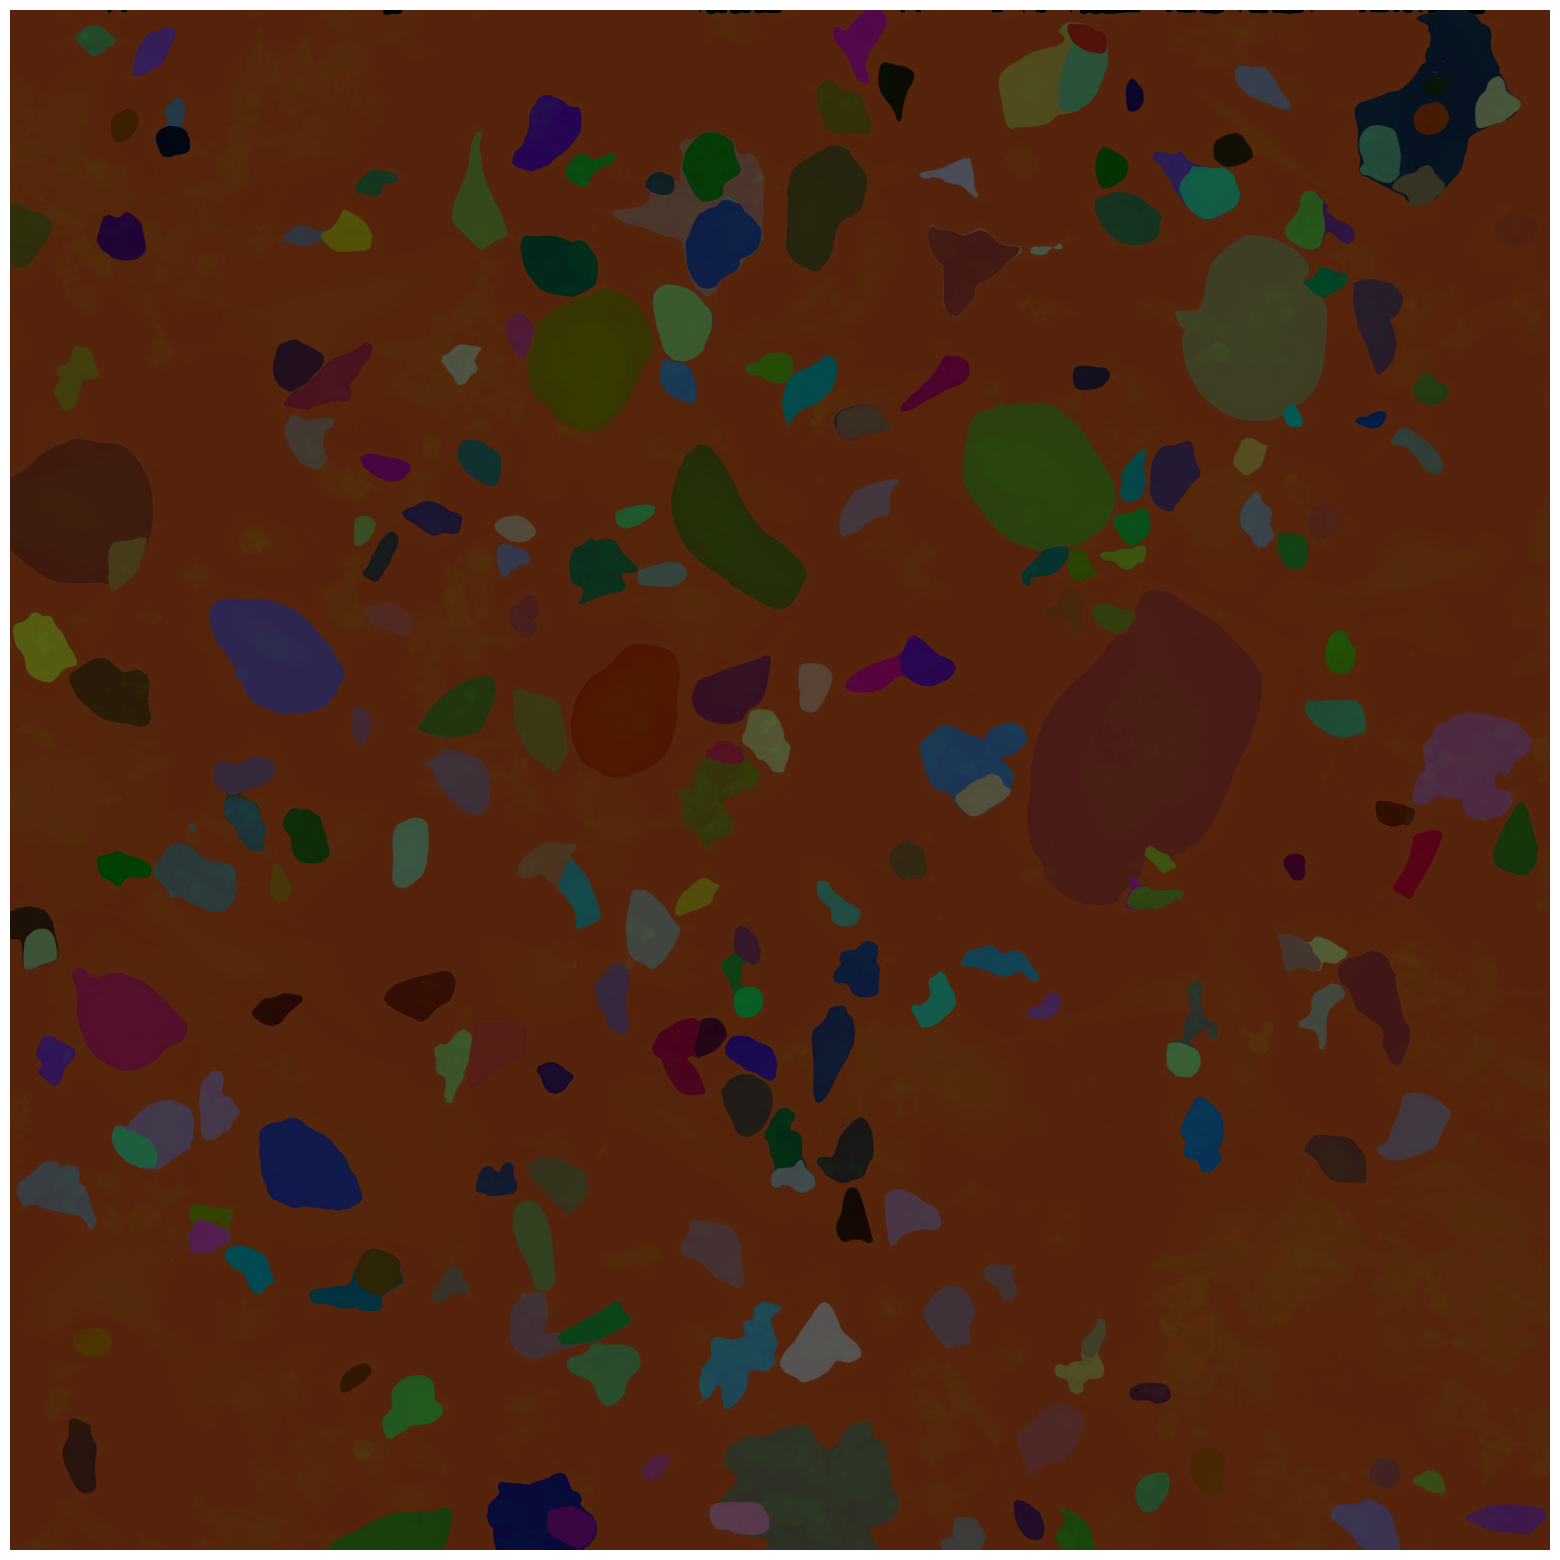

In [67]:
plt.figure(figsize=(20,20))
plt.imshow(test_frame_rgb_8bit)
show_anns(anns)
plt.axis('off')
plt.show() 

In [ ]:
masks = return_anns(masks)


In [66]:
v.add_image(masks)

<Image layer 'masks' at 0x7f96740ea190>

In [65]:
v.add_labels(masks.astype(int))

<Labels layer 'Labels' at 0x7f9677ca8f10>

### Test on 1ch images

In [76]:
%%time
ch1_16bit = test_frame[0].compute().compute()
ch2_16bit = test_frame[1].compute().compute()

CPU times: user 2min 39s, sys: 26.3 s, total: 3min 5s
Wall time: 36 s


In [78]:
%%time
ch1_8bit = cv2.convertScaleAbs(ch1_16bit, alpha=(255.0/65535.0))
ch2_8bit = cv2.convertScaleAbs(ch2_16bit, alpha=(255.0/65535.0))

CPU times: user 33.8 ms, sys: 24.6 ms, total: 58.5 ms
Wall time: 63.2 ms


In [82]:
ch1_rgb = np.zeros(ch1_8bit.shape + (3,),  dtype=ch1_8bit.dtype)# rgb_image = np.zeros((6048, 6048, 3), dtype=img.dtype)

# Assign the first channel of img to the green channel in the RGB image
ch1_rgb[:, :, 1] = ch1_8bit 

ch2_rgb = np.zeros(ch2_8bit.shape + (3,),  dtype=ch2_8bit.dtype)# rgb_image = np.zeros((6048, 6048, 3), dtype=img.dtype)

# Assign the first channel of img to the green channel in the RGB image
ch2_rgb[:, :, 0] = ch2_8bit 

In [85]:
%%time
ch1_anns = mask_generator.generate(ch1_rgb)
ch2_anns = mask_generator.generate(ch2_rgb)

CPU times: user 1h 17min 44s, sys: 28min 17s, total: 1h 46min 1s
Wall time: 31min 44s


In [96]:
import pickle

# Your list of dictionaries containing NumPy arrays


# Define a file path where you want to save the list
file_path = './sam_test_seg/ch2.pkl'

# Use pickle to save the list to the file
with open(file_path, 'wb') as file:
    pickle.dump(ch2_anns, file)

print(f'The list of dictionaries has been saved to {file_path}')

The list of dictionaries has been saved to ./sam_test_seg/ch2.pkl


In [93]:
ch1_anns

[{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]),
  'area': 36578304,
  'bbox': [0, 0, 6047, 6047],
  'predicted_iou': 1.0505127906799316,
  'point_coords': [[2929.5, 5953.5]],
  'stability_score': 0.9998337626457214,
  'crop_box': [0, 0, 6048, 6048]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 3453,
  'bbox': [1601, 3850

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [10]:
print(len(masks))
print(masks[0].keys())

591
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

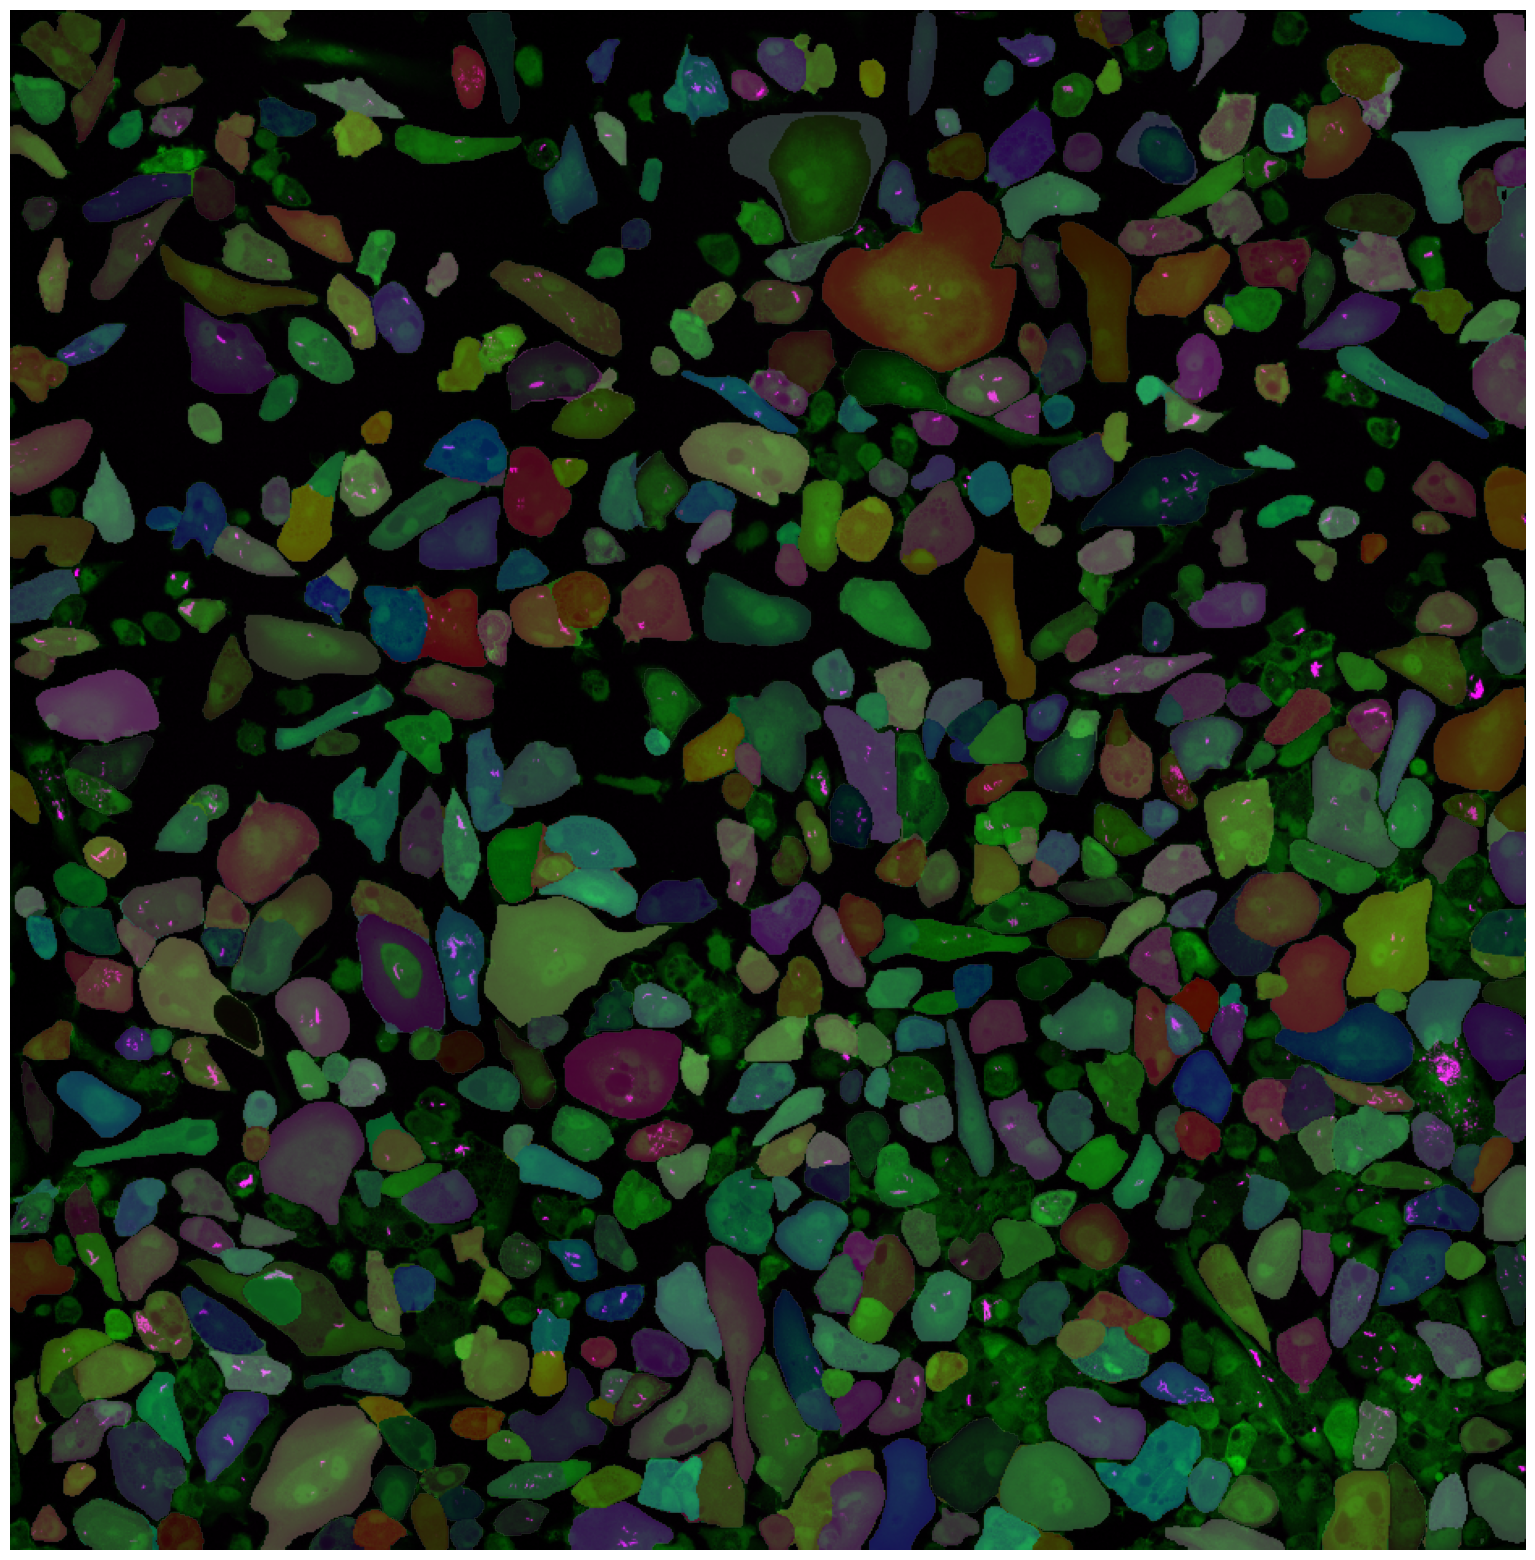

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [12]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [13]:
for i in  
masks2 = mask_generator_2.generate(image)

In [14]:
len(masks2)

797

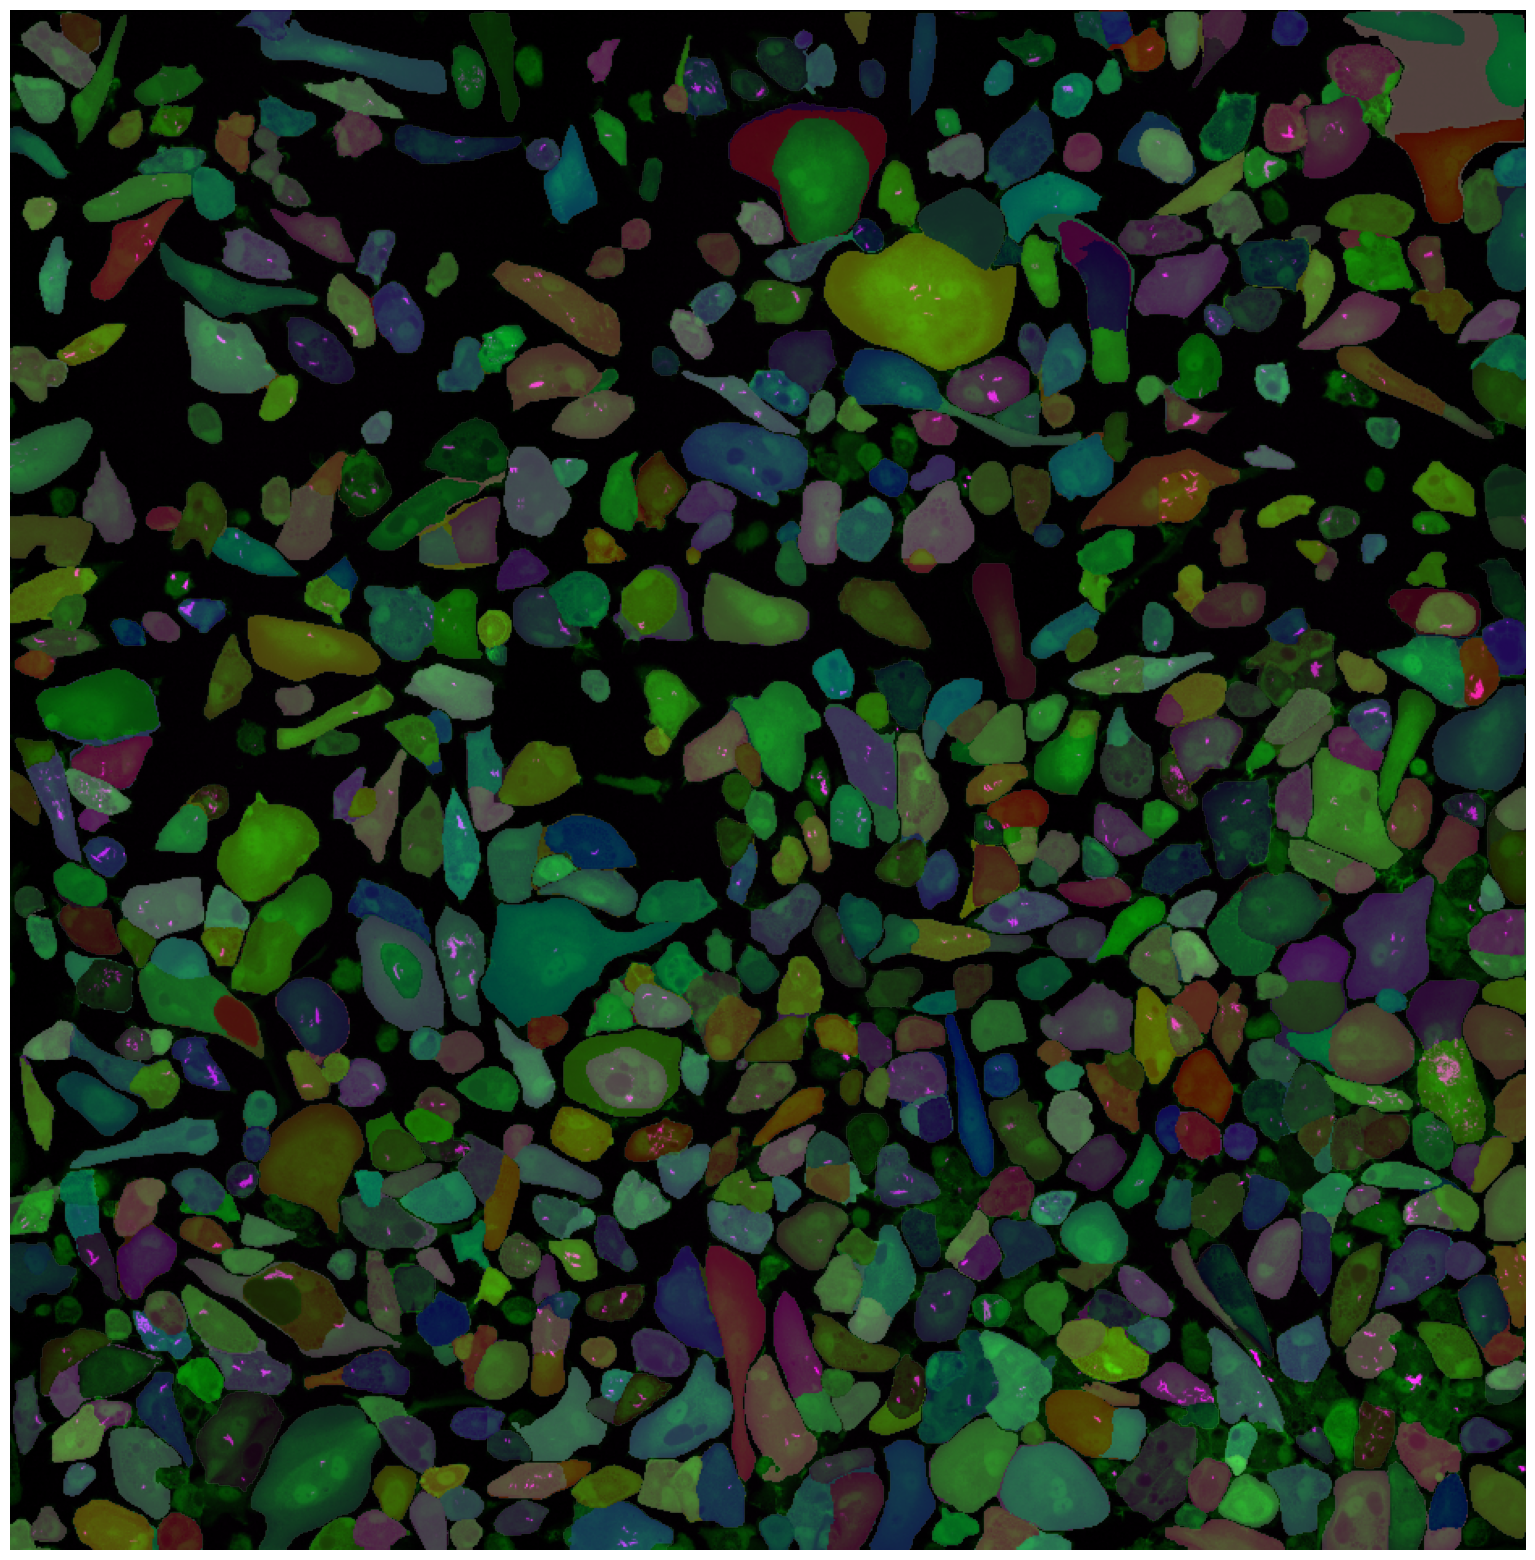

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [16]:
import napari

In [39]:
height, width = ch1_masks[0]['segmentation'].shape
ch1_seg = np.zeros((height, width), dtype=np.uint8) 
height, width = ch2_masks[0]['segmentation'].shape
ch2_seg = np.zeros((height, width), dtype=np.uint8) 

# Function to generate a random color
def random_color():
    return np.random.randint(0, 255)

# Apply each mask to the blank image
for mask_dict in ch1_masks:
    mask = mask_dict['segmentation']
    color = random_color()
    ch1_seg[mask] = color

for mask_dict in ch2_masks:
    mask = mask_dict['segmentation']
    color = random_color()
    ch2_seg[mask] = color

In [40]:
viewer = napari.Viewer()

viewer.add_image(image)
viewer.add_labels(ch1_seg)
viewer.add_labels(ch2_seg)

<Labels layer 'ch2_seg' at 0x7f247488f070>

# Testing a bunch of different params 

In [47]:
# Get the dimensions of the array
height, width = ch1_seg.shape

# Calculate the size in bytes (since np.uint8 is 1 byte)
size_in_bytes = height * width * 1  # 1 byte per pixel

# Convert bytes to megabytes
size_in_megabytes = size_in_bytes / (1024 * 1024)
size_in_megabytes

0.8488845825195312

In [48]:
output_dir = '/mnt/SYNO/macrohet_syno/ND0002/upstream_development/'

In [54]:
from tqdm.auto import tqdm
import itertools
import os

In [55]:
# Parameter ranges to test
points_per_side_options = [16, 32, 64]
pred_iou_thresh_options = [0.80, 0.85, 0.90]
stability_score_thresh_options = [0.90, 0.92, 0.95]
# Add more parameters if needed

def random_color():
    return np.random.randint(0, 255)

# Prepare all combinations of parameters
all_combinations = list(itertools.product(
    points_per_side_options, pred_iou_thresh_options, stability_score_thresh_options))

# Iterate over all combinations of parameters with tqdm for progress bar
for points_per_side, pred_iou_thresh, stability_score_thresh in tqdm(all_combinations, desc="Processing Combinations"):

    # Initialize mask generator with current parameters
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        # Add other parameters as needed
    )

    # Generate masks
    ch1_masks = mask_generator.generate(ch1)
    ch2_masks = mask_generator.generate(ch2)

    # Process masks for ch1
    height, width = ch1_masks[0]['segmentation'].shape
    ch1_seg = np.zeros((height, width), dtype=np.uint8)
    for mask_dict in ch1_masks:
        mask = mask_dict['segmentation']
        ch1_seg[mask] = random_color()

    # Process masks for ch2
    height, width = ch2_masks[0]['segmentation'].shape
    ch2_seg = np.zeros((height, width), dtype=np.uint8)
    for mask_dict in ch2_masks:
        mask = mask_dict['segmentation']
        ch2_seg[mask] = random_color()

    # Save the segmentation images
    params_str = f"pps{points_per_side}_iou{pred_iou_thresh}_stab{stability_score_thresh}"
    cv2.imwrite(os.path.join(output_dir, f"ch1_seg_{params_str}.png"), ch1_seg)
    cv2.imwrite(os.path.join(output_dir, f"ch2_seg_{params_str}.png"), ch2_seg)

# Add necessary imports and handle potential exceptions as needed


Processing Combinations:  52%|█████████████████                | 14/27 [20:42<19:13, 88.74s/it]


RuntimeError: out_ptr == out_accessor[thread_count_nonzero[tid + 1]].data() INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1702400260593/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp":2336, please report a bug to PyTorch. 

In [ ]:
# Parameter ranges to test with more options
points_per_side_options = [16, 24, 32, 48, 64]
pred_iou_thresh_options = [0.75, 0.80, 0.85, 0.90, 0.95]
stability_score_thresh_options = [0.88, 0.90, 0.92, 0.94, 0.96]
# Add more parameters if needed

def random_color():
    return np.random.randint(0, 255)

# Prepare all combinations of parameters
all_combinations = list(itertools.product(
    points_per_side_options, pred_iou_thresh_options, stability_score_thresh_options))

# Iterate over all combinations of parameters with tqdm for progress bar
for points_per_side, pred_iou_thresh, stability_score_thresh in tqdm(all_combinations, desc="Processing Combinations"):

    # Initialize mask generator with current parameters
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        # Add other parameters as needed
    )

    # Generate masks
    ch1_masks = mask_generator.generate(ch1)
    ch2_masks = mask_generator.generate(ch2)

    # Process masks and create overlay for ch1
    height, width = ch1_masks[0]['segmentation'].shape
    ch1_seg = np.zeros((height, width), dtype=np.uint8)
    ch1_overlay = ch1.copy()
    for mask_dict in ch1_masks:
        mask = mask_dict['segmentation']
        color = random_color()
        ch1_seg[mask] = color
        ch1_overlay[mask] = ch1_overlay[mask] * 0.5 + np.array(color) * 0.5

    # Process masks and create overlay for ch2
    height, width = ch2_masks[0]['segmentation'].shape
    ch2_seg = np.zeros((height, width), dtype=np.uint8)
    ch2_overlay = ch2.copy()
    for mask_dict in ch2_masks:
        mask = mask_dict['segmentation']
        color = random_color()
        ch2_seg[mask] = color
        ch2_overlay[mask] = ch2_overlay[mask] * 0.5 + np.array(color) * 0.5

    # Save the segmentation images and overlays
    params_str = f"pps{points_per_side}_iou{pred_iou_thresh}_stab{stability_score_thresh}"
    cv2.imwrite(os.path.join(output_dir, f"ch1_seg_{params_str}.png"), ch1_seg)
    cv2.imwrite(os.path.join(output_dir, f"ch2_seg_{params_str}.png"), ch2_seg)
    cv2.imwrite(os.path.join(output_dir, f"ch1_overlay_{params_str}.png"), ch1_overlay)
    cv2.imwrite(os.path.join(output_dir, f"ch2_overlay_{params_str}.png"), ch2_overlay)
